In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import cartopy.io.shapereader as shpreader
from shapely.geometry import box
import shapely.vectorized as sv
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def average_capacity_factors(filename):
    '''
    Function to read in a .nc file and calculate the average capacity factors over time.
    '''
    ds = xr.open_dataset(filename)

    cf_avg = ds.mean(dim='time')

    return cf_avg

def get_top_60_percent_cfs(avg_capacity_factors):
    '''
    Function to get the top 60% of capacity factors.
    '''
    cfs_60 = avg_capacity_factors.where(avg_capacity_factors > avg_capacity_factors.quantile(0.75), -1)

    # Assuming 'variable_name' is the name of the variable in the Dataset
    num_cfs_60 = cfs_60['capacity factor'].where(cfs_60['capacity factor'] != -1).notnull().sum().item()
    print(f"Number of grid cells in the top 60%: {num_cfs_60}/{cfs_60['capacity factor'].size}")

    return cfs_60

In [3]:
def get_time_series_top_60_percent_cfs(filename, cfs_60, cf_type):
    '''
    Function to get the time series of the top 60% of capacity factors.
    '''
    ds = xr.open_dataset(filename)

    # Save average over all grid cells to csv file
    ds_avg = ds.mean(dim=['x', 'y'])
    ds_avg_df = ds_avg.to_dataframe()
    ds_avg_df = ds_avg_df.rename(columns={'capacity factor': f'{cf_type}_cf_avg'})
    year = filename.split('_')[-1].split('.')[0]
    # ds_avg_df.to_csv(f'CONUS_{cf_type}_CF_avg_all_{year}.csv')

    # Get time series of top 60% grid cells
    cfs_60_ts = ds.where(cfs_60 > 0)

    # Average over all grid cells
    cfs_60_ts = cfs_60_ts.mean(dim=['x', 'y'])

    # Write to csv file
    cfs_60_df = cfs_60_ts.to_dataframe()

    # Drop columns execpt for time and capacity factor
    cfs_60_df = cfs_60_df.drop(columns=['quantile'])
    # Rename columns
    cfs_60_df = cfs_60_df.rename(columns={'capacity factor': f'{cf_type}_cf'})
    
    # Write to csv file
    year = filename.split('_')[-1].split('.')[0]
    cfs_60_df.to_csv(f'CONUS_{cf_type}_CF_{year}.csv')

In [4]:
def plot_capacity_factor(cf, cap_fac_type):
    """
    Plot map of capacity factor
    """

    shpfilename = shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
    reader = shpreader.Reader(shpfilename)
    # Mask US 
    US = gpd.GeoSeries(
        {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
        crs={"init": "epsg:4326"}).reindex(["United States of America"])

    # Only keep contiguous US
    contiguous_48_bbox = box(minx=-160, miny=24.396308, maxx=-66.93457, maxy=49.384358)
    # Clip the US geometry to the bounding box
    conus = US.geometry.intersection(contiguous_48_bbox)
    # Mask the capacity factor data to the US geometry
    # Extract the geometry from the GeoSeries (use unary_union if there are multiple polygons)
    conus_geom = conus.unary_union if len(conus) > 1 else conus.iloc[0]

    # Get the grid of coordinates (lon, lat) from the xarray DataArray
    lon, lat = np.meshgrid(cf['x'], cf['y'])

    # Use shapely's vectorized.contains to create a mask for points within the conus
    mask = sv.contains(conus_geom, lon, lat)

    # Apply the mask to the cf DataArray
    masked_dataset = cf.where(mask)

    # Set aspect ratio
    aspect_ratio = (cf['x'].max()-cf['x'].min())/(cf['y'].max()-cf['y'].min())
    # Set color scale limits
    masked_dataset["capacity factor"].plot(aspect=aspect_ratio, size=5, vmin=0.)
    plt.title(f'{cap_fac_type} 2019-2023 average')
    # Save plot
    plt.savefig(f'capacity_factor_{cap_fac_type.replace(" ","").replace("%","")}.jpg')

    # Print mean capacity factor without zeros
    print(masked_dataset["capacity factor"].where(masked_dataset["capacity factor"] > 0).mean().values)


In [5]:
def get_60_percent_cf_all(cf_type):
    """
    Get the top 60% capacity factors for all years
    """

    cf_avg_2019 = average_capacity_factors(f'conus_{cf_type}_CF_timeseries_2019.nc')
    cf_avg_2020 = average_capacity_factors(f'conus_{cf_type}_CF_timeseries_2020.nc')
    cf_avg_2021 = average_capacity_factors(f'conus_{cf_type}_CF_timeseries_2021.nc')
    cf_avg_2022 = average_capacity_factors(f'conus_{cf_type}_CF_timeseries_2022.nc')
    cf_avg_2023 = average_capacity_factors(f'conus_{cf_type}_CF_timeseries_2023.nc')

    cf_avg_all = (cf_avg_2019 + cf_avg_2020 + cf_avg_2021 + cf_avg_2022 + cf_avg_2023)/5

    # Plot 
    plot_capacity_factor(cf_avg_all, cf_type)
    cf_all_60 = get_top_60_percent_cfs(cf_avg_all)
    plot_capacity_factor(cf_all_60, cf_type+" top 60%")

    cfs = []
    for year in range(2019, 2024):

        cf_ts = xr.open_dataset(f'conus_{cf_type}_CF_timeseries_{year}.nc')

        # Only keep the capacity factors that are non-zero in cf_all_60
        cf_ts = cf_ts.where(cf_all_60 > -1)

        # Average over all grid cells
        cf_ts = cf_ts.mean(dim=['x', 'y'])

        cfs.append(cf_ts)

    cf_ts_all = xr.concat(cfs, dim='time')
    # Drop quantile dimension
    cf_ts_all = cf_ts_all.drop('quantile')
    # Rename capacity factor dimension
    cf_ts_all = cf_ts_all.rename({'capacity factor': f'{cf_type}_cf'})
    # Write to csv file
    cf_ts_all_df = cf_ts_all.to_dataframe()
    cf_ts_all_df.to_csv(f'CONUS_{cf_type}_CF_2019_2023.csv')


/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


0.23150903107259238
Number of grid cells in the top 60%: 5717/22869


/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


0.27683614617414415


/tmp/ipykernel_1890363/1009356869.py:34: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  cf_ts_all = cf_ts_all.drop('quantile')
/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


0.2031717797266823
Number of grid cells in the top 60%: 5717/22869


/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


0.39879593064592267


/tmp/ipykernel_1890363/1009356869.py:34: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  cf_ts_all = cf_ts_all.drop('quantile')


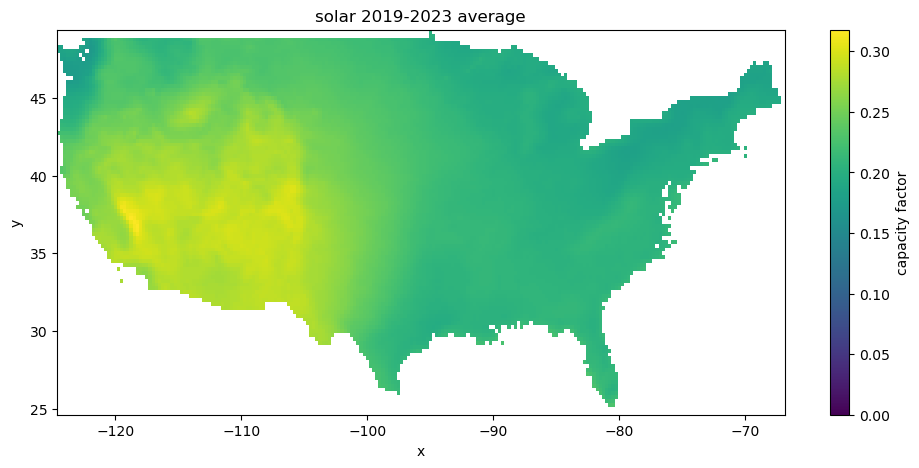

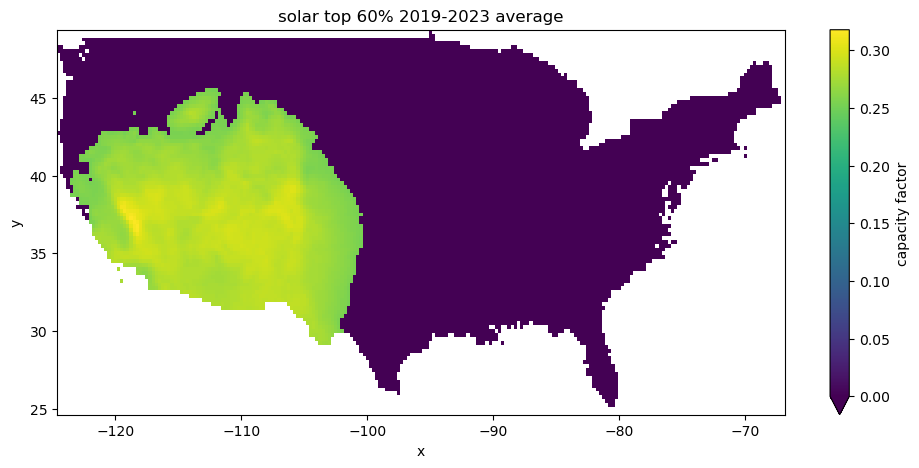

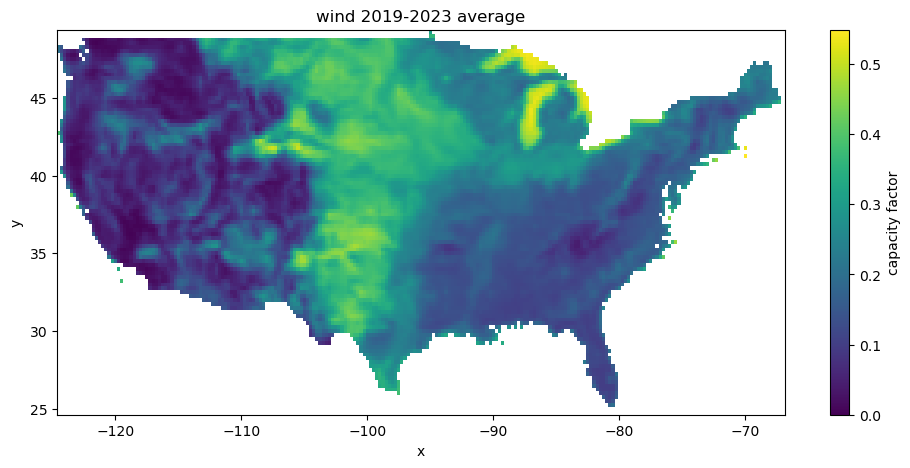

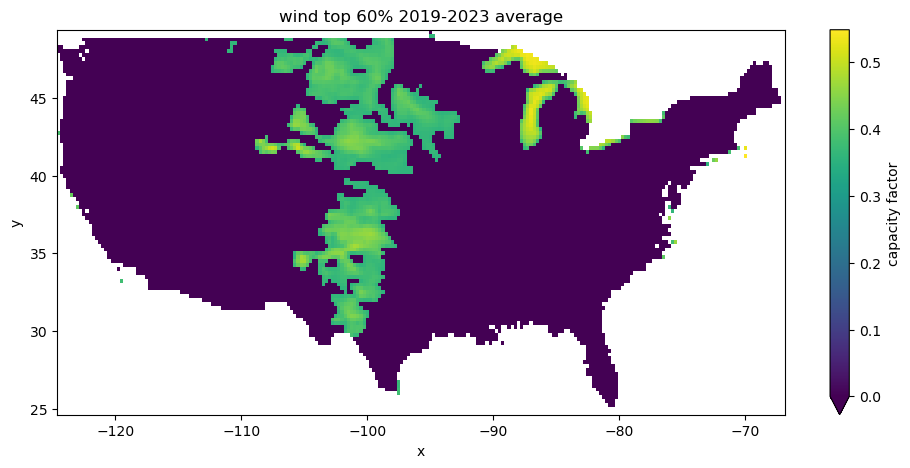

In [6]:
get_60_percent_cf_all('solar')
get_60_percent_cf_all('wind')

In [7]:
def read_csv_file(filename):
    """
    Read csv file
    """
    df = pd.read_csv(filename)
    # Print mean of columm 1
    print(df.iloc[:,1].mean())

# Source for reported capacity factors:
# https://www.eia.gov/electricity/monthly/epm_table_grapher.php?t=table_6_07_b
print("Solar")
print("Reported 5 year average of capacity factors")
print((24.3+24.2+24.4+24.4+23.2)/5./100.)
print("Mean capacity factor of top 60% of grid cells")
read_csv_file('CONUS_solar_CF_2019_2023.csv')

print("\n")
print("Wind")
print("Reported 5 year average of capacity factors")
print((34.4+35.3+34.4+35.9+33.2)/5./100.)
print("Mean capacity factor of top 60% of grid cells")
read_csv_file('CONUS_wind_CF_2019_2023.csv')

Solar
Reported 5 year average of capacity factors
0.24100000000000002
Mean capacity factor of top 60% of grid cells
0.27651497886822685


Wind
Reported 5 year average of capacity factors
0.3464
Mean capacity factor of top 60% of grid cells
0.4425943929582439
